In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from sklearn.manifold import TSNE
from umap import UMAP

from janus.datasets import Boyd2019
from janus.viz import xy_plot, norm_crop_for_vis

data_path = '../data/boyd_2019'
metadata_file = '../data/boyd_2019_PlateMap-KPP_MOA.xlsx'

metadata = Boyd2019.read_metadata(metadata_file)

# filter by 2 moas and make train test
metadata = metadata.loc[metadata.moa.isin(['Neutral', 'EGF Receptor Kinase Inhibitor'])]
train_metadata = metadata.sample(frac=0.7)
test_metadata = metadata.drop(train_metadata.index)

boyd2019 = Boyd2019(data_path, train_metadata, padding=64, scale=0.5)

mda231 = torch.cat([x[0][None] for x in boyd2019.dataset_1], axis=0)
mda468 = torch.cat([x[0][None] for x in boyd2019.dataset_2], axis=0)

print(mda231.shape, mda468.shape)

computing normalization parameters
computing normalization parameters
torch.Size([11410, 3, 64, 64]) torch.Size([7919, 3, 64, 64])


## Raw pixels

In [17]:
nb_samples = 2000
labels = nb_samples // 2 * ['mda231'] + nb_samples // 2 * ['mda468']

idx = torch.randint(0, mda231.shape[0], (nb_samples // 2,))
mda231_samples = mda231[idx]

idx = torch.randint(0, mda468.shape[0], (nb_samples // 2,))
mda468_samples = mda468[idx]

all_samples = torch.cat([mda231_samples, mda468_samples], axis=0)
print(torch.min(all_samples), torch.max(all_samples))

tensor(-2.6896) tensor(48.9624)


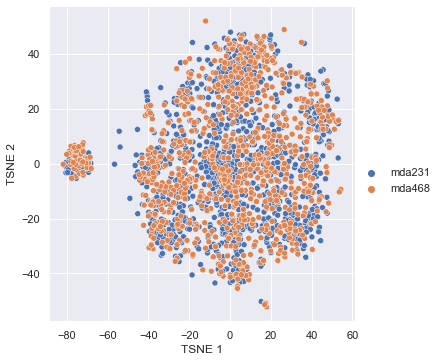

In [13]:
x_emb = TSNE().fit_transform(all_samples.reshape(nb_samples, -1))
xy_plot(x_emb, labels, 'TSNE')

## Raw pixels - unnormalised

In [4]:
norm_mda231 = [norm_crop_for_vis(x).permute((2, 0, 1))[None] for x in mda231_samples]
norm_mda468 = [norm_crop_for_vis(x).permute((2, 0, 1))[None] for x in mda468_samples]

all_samples_un = torch.cat([torch.cat(norm_mda231), torch.cat(norm_mda468)], axis=0)

print(torch.min(all_samples_un), torch.max(all_samples_un))

tensor(0.) tensor(1.)


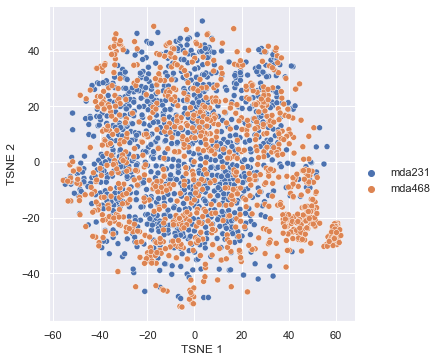

In [14]:
x_emb = TSNE().fit_transform(all_samples_un.reshape(nb_samples, -1))
xy_plot(x_emb, labels, 'TSNE')

## VGG features

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.eval()

def vgg_features(inputs):

    x = vgg16.features(inputs)
    x = vgg16.avgpool(x)
    x = torch.flatten(x, 1)
    x = vgg16.classifier[:5](x)

    return x

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)

In [7]:
cnn_codes = torch.empty((0,))

for i in range(nb_samples):
    inputs = all_samples[i:i+1]
    inputs = (inputs - vgg_mean) / vgg_std
    inputs = F.interpolate(inputs, size=224, mode='bilinear')
    cnn_codes = torch.cat([cnn_codes, vgg_features(inputs).detach()])

/Users/jcboyd/Documents/janus/env/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


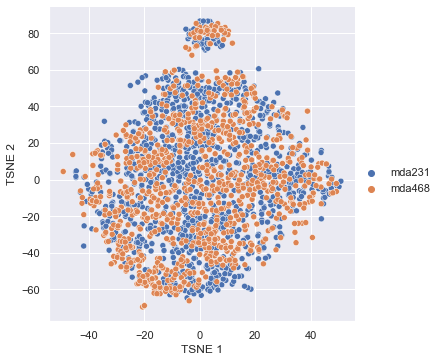

In [15]:
x_emb = TSNE().fit_transform(cnn_codes.reshape(nb_samples, -1))
xy_plot(x_emb, labels, 'TSNE')

## VGG features - unnormalised

In [9]:
cnn_codes_un = torch.empty((0,))

for i in range(nb_samples):
    inputs = all_samples_un[i:i+1]
    inputs = (inputs - vgg_mean) / vgg_std
    inputs = F.interpolate(inputs, size=224, mode='bilinear')
    cnn_codes_un = torch.cat([cnn_codes_un, vgg_features(inputs).detach()])

/Users/jcboyd/Documents/janus/env/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


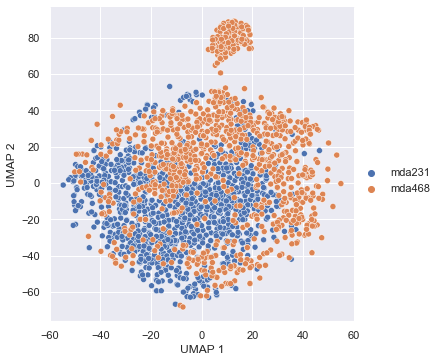

In [11]:
x_emb = TSNE().fit_transform(cnn_codes_un.reshape(nb_samples, -1))
xy_plot(x_emb, labels, 'TSNE')